# **Brain Tumor Classification Using Deep Learning (CNN)**

This project aimed to build a Convolutional Neural Network based deep learning model to first identify brain tumors and then classify them as Benign Tumors, Malignant Tumors or Pituitary Tumors.

# Dataset
* **[Dataset](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data)**

# Install Required Packages

In [ ]:
!pip install -r requirements.txt

# Import Libraries

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

# Configure Tensorboard

In [2]:
log_dir = "log/resnet50/" + tf.timestamp().numpy().astype(str)
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

2024-12-14 18:43:28.898588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-14 18:43:29.069953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-14 18:43:29.070013: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-14 18:43:29.074326: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-14 18:43:29.074387: I external/local_xla/xla/stream_executor

In [3]:
# Clear any logs from previous runs
!rm -rf ./log/resnet50/

# Set Hyperparameters

In [4]:
X_train = []
Y_train = []
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

IMG_SIZE = 224
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
CLASSES = len(labels)
EPOCH = 20
BATCH_SIZE = 4

# Data Preprocessing

In [5]:
for i in labels:
    folderPath = os.path.join('dataset/Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        X_train.append(img)
        Y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('dataset/Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        X_train.append(img)
        Y_train.append(i)

In [6]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)

print('x train shape : ',X_train.shape)
print('y train shape : ', Y_train.shape)

x train shape :  (3264, 224, 224, 3)
y train shape :  (3264,)


## Train Test Split

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

## One Hot Encoding

In [8]:
y_train_new = []
for i in Y_train:
    y_train_new.append(labels.index(i))
Y_train=y_train_new
Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_new = []
for i in Y_test:
    y_test_new.append(labels.index(i))
Y_test=y_test_new
Y_test = tf.keras.utils.to_categorical(Y_test)

# Build Model

## Download ResNet50 Model

In [9]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=INPUT_SHAPE)

In [10]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

## Freeze the layers

In [11]:
for layer in base_model.layers[:33]:
    layer.trainable = False

## Custom Model

In [12]:
model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(CLASSES, activation='softmax')
])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          589856    
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

## Compile Model

In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Set Callbacks

In [15]:
callbacks = [
    ModelCheckpoint(filepath='model/resnet50/resnet50.keras', monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', verbose=1, patience=5),
    tensorboard
]

# Start Tensorboard

In [16]:
%load_ext tensorboard
%tensorboard --logdir=log/resnet50/

Reusing TensorBoard on port 6006 (pid 339592), started 3:48:35 ago. (Use '!kill 339592' to kill it.)

# Fit the Model

In [17]:
history = model.fit(X_train,
                    Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCH,
                    validation_data=(X_test, Y_test),
                    callbacks=callbacks
)

Epoch 1/20


2024-12-14 18:45:06.362479: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-14 18:45:10.831202: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdea9cdf610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-14 18:45:10.831235: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-12-14 18:45:10.845818: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734191110.939775  426987 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


653/653 [==============================] - ETA: 0s - loss: 1.2957 - accuracy: 0.3818
Epoch 1: val_loss improved from inf to 1.86073, saving model to model/resnet50/resnet50.keras
653/653 [==============================] - 87s 92ms/step - loss: 1.2957 - accuracy: 0.3818 - val_loss: 1.8607 - val_accuracy: 0.3691 - lr: 0.0010
Epoch 2/20
651/653 [============================>.] - ETA: 0s - loss: 1.0962 - accuracy: 0.5169
Epoch 2: val_loss improved from 1.86073 to 1.20823, saving model to model/resnet50/resnet50.keras
653/653 [==============================] - 48s 73ms/step - loss: 1.0951 - accuracy: 0.5178 - val_loss: 1.2082 - val_accuracy: 0.4181 - lr: 0.0010
Epoch 3/20
653/653 [==============================] - ETA: 0s - loss: 0.9141 - accuracy: 0.6128
Epoch 3: val_loss improved from 1.20823 to 0.84988, saving model to model/resnet50/resnet50.keras
653/653 [==============================] - 50s 76ms/step - loss: 0.9141 - accuracy: 0.6128 - val_loss: 0.8499 - val_accuracy: 0.6371 - lr: 0.

# Evaluate the model

## Classification Report

In [18]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)

print(classification_report(Y_test, y_pred, target_names=labels))
print('Test Accuracy:', accuracy_score(Y_test, y_pred))

21/21 [==============================] - 9s 217ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.83      0.86       219
meningioma_tumor       0.76      0.80      0.78       187
        no_tumor       0.85      0.89      0.87        87
 pituitary_tumor       0.94      0.93      0.93       160

        accuracy                           0.85       653
       macro avg       0.86      0.86      0.86       653
    weighted avg       0.86      0.85      0.86       653

Test Accuracy: 0.8545176110260337


# visualize training history

## Accuracy

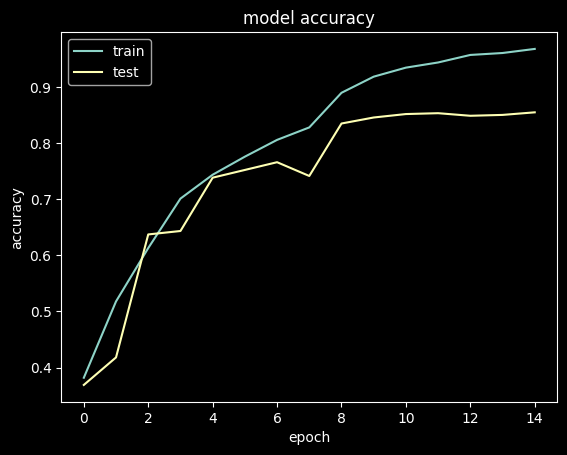

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loss

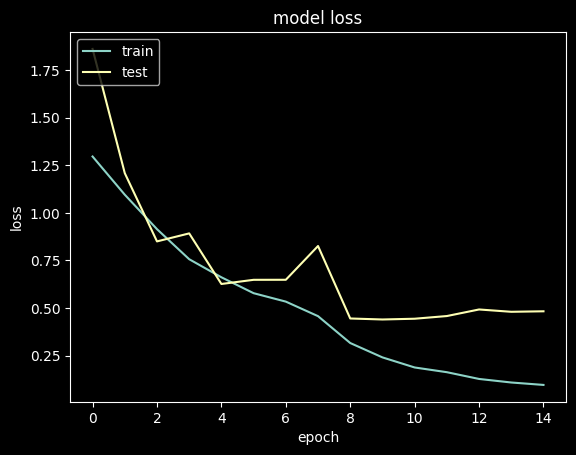

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Confusion Matrix

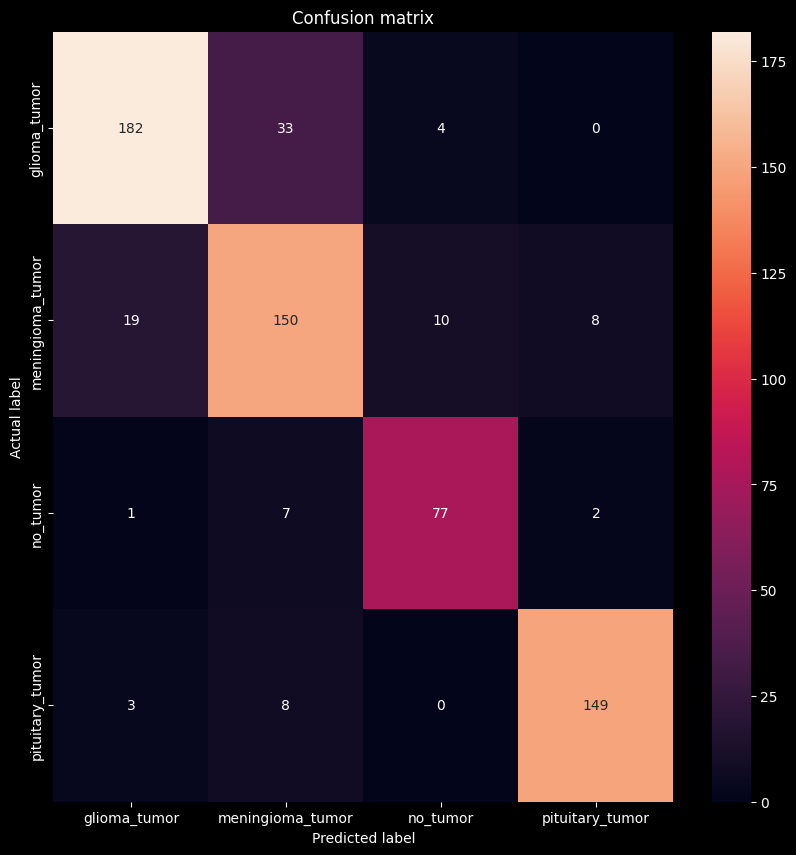

In [21]:
cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Save the Model

In [22]:
model.save('model/resnet50/resnet50.keras')

# Load the Model

In [24]:
model = load_model('model/resnet50/resnet50.keras')

# Predict

1/1 [==============================] - 0s 31ms/step
The MRI is :  no_tumor


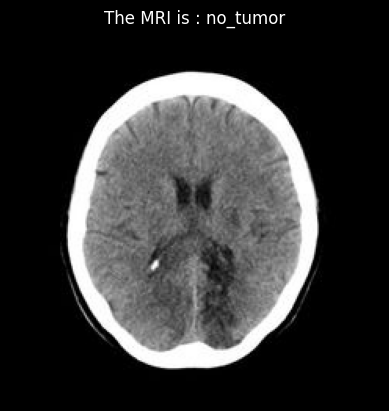

In [28]:
# Load the image file
image_path = 'dataset/Testing/no_tumor/image(16).jpg'

img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = np.reshape(img, [1, IMG_SIZE, IMG_SIZE, 3])

# Predict the image
prediction = model.predict(img)
prediction = labels[np.argmax(prediction)]
print('The MRI is : ', prediction)

# Display the image
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('The MRI is : ' + prediction)
plt.axis('off')
plt.show()